In [1]:
import os
import cv2
import torch
import random
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
FILE_PATH= "/kaggle/input/shop-lifter/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4" # Example to test functions
video_path = '/kaggle/input/shop-lifter/Shop DataSet'  # Path to your dataset
# Parameters
num_frames = 100               # Number of frames to extract from each video
height, width = 100, 100        # Dimensions to resize each frame
channels = 3                  # Number of channels (RGB)
batch_size = 4                # Batch size for training
epochs = 10                   # Number of training epochs



In [3]:
class_names = []
video_counts = []
for label, class_name in enumerate(os.listdir(video_path)):
    class_path = os.path.join(video_path, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory (class folder)
        class_names.append(class_name)
        video_counts.append(len(os.listdir(class_path)))
        

In [4]:
label = []
for i, loops in enumerate(video_counts):
    for j in range(loops):
        label.append(i)
print(len(label))    

855


In [5]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label),
    y=label
)

# Convert to a dictionary
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict) 

{0: 0.8050847457627118, 1: 1.3194444444444444}


In [6]:
all_videos = []
for label, class_name in enumerate(os.listdir(video_path)):
    class_path = os.path.join(video_path, class_name)
    if os.path.isdir(class_path):
        for video_name in os.listdir(class_path):
            video_file = os.path.join(class_path, video_name)
            if video_file.endswith('.mp4'):  # Adjust for your video format
                all_videos.append((video_file, label))

# Split into training and testing sets
train_videos, test_videos = train_test_split(all_videos, test_size=0.2, stratify=[label for _, label in all_videos], random_state=42)

print(f"Total videos: {len(all_videos)}")
print(f"Training videos: {len(train_videos)}")
print(f"Testing videos: {len(test_videos)}")

Total videos: 855
Training videos: 684
Testing videos: 171


In [7]:
def video_generator(videos, batch_size, num_frames, height, width, channels, class_weights):
    """Generator function to yield video batches with class weights from pre-defined video list."""
    while True:  # Loop indefinitely
        random.shuffle(videos)  # Shuffle the videos for each epoch

        data = []
        labels = []
        weights = []

        # Iterate through the shuffled list of videos
        for video_file, label in videos:
            frames = []
            cap = cv2.VideoCapture(video_file)

            if not cap.isOpened():
                print(f"Error opening video file {video_file}")
                continue

            frame_count = 0
            # Read frames from the video
            while cap.isOpened() and frame_count < num_frames:
                ret, frame = cap.read()
                if not ret:
                    break
                # Resize frame and append to the frames list
                frame = cv2.resize(frame, (width, height))
                frame = frame.astype('float32') / 255.0
                frames.append(frame)
                frame_count += 1
            
            cap.release()

            # If the video has fewer frames than required, pad with zeros
            while len(frames) < num_frames:
                frames.append(np.zeros((height, width, channels), dtype=np.uint8))

            # Convert frames list to numpy array
            frames = np.array(frames)

            # Append the processed video, its label, and the corresponding weight
            data.append(frames)
            labels.append(label)
#             weights.append(class_weights[label])  # Use class_weights

            # Yield batch of videos when data list reaches batch_size
            if len(data) == batch_size:
#                 yield np.array(data), np.array(labels), np.array(weights)
                yield np.array(data), np.array(labels)
                data = []  # Reset data list for the next batch
                labels = []  # Reset labels list for the next batch
#                 weights = []  # Reset weights list for the next batch

        # If there are leftover videos that don't fill a full batch, yield them
        if len(data) > 0:
#             yield np.array(data), np.array(labels), np.array(weights)
            yield np.array(data), np.array(labels)


In [8]:
# Create the generators
gen = video_generator(train_videos, batch_size, num_frames, height, width, channels, class_weights)
test_gen = video_generator(test_videos, batch_size, num_frames, height, width, channels, class_weights)

In [9]:
for batch in gen:
    videos , labels = batch
    print(videos.shape)
    print(labels)
#     print(weights)
    break

(4, 100, 100, 100, 3)
[1 0 0 0]


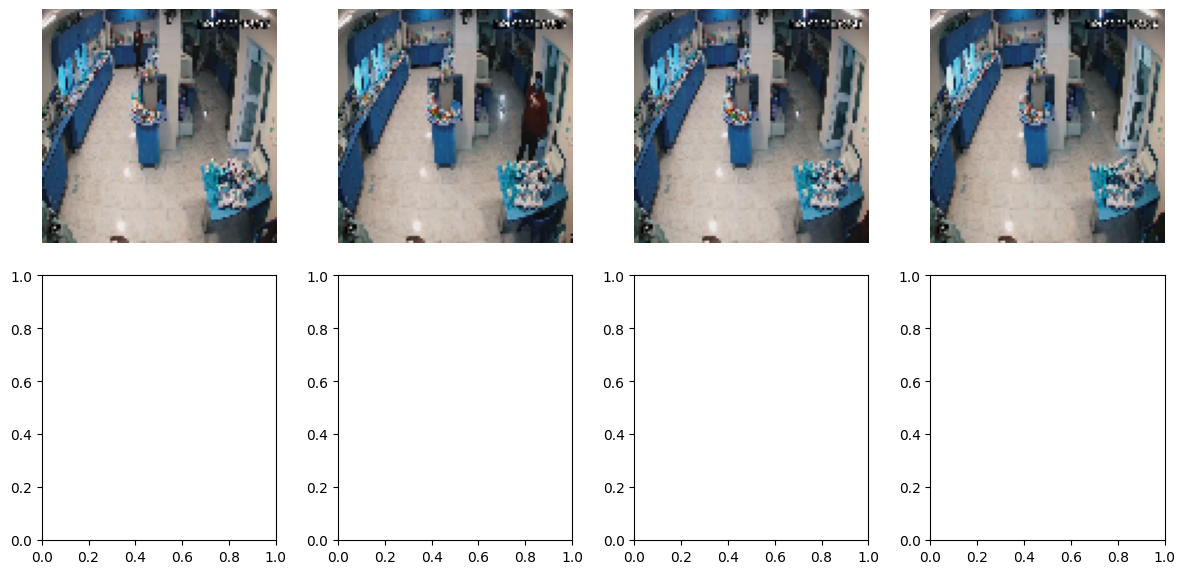

In [10]:

def plot_images(video_list):
    """Plot a list of 8 images in a 2x4 grid."""
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))  
    axes = axes.flatten()  
    
    for i, video in enumerate(video_list):
        axes[i].imshow(video[20,:,:,:])
        axes[i].axis('off')  

    plt.tight_layout()
    plt.show()


plot_images(videos)


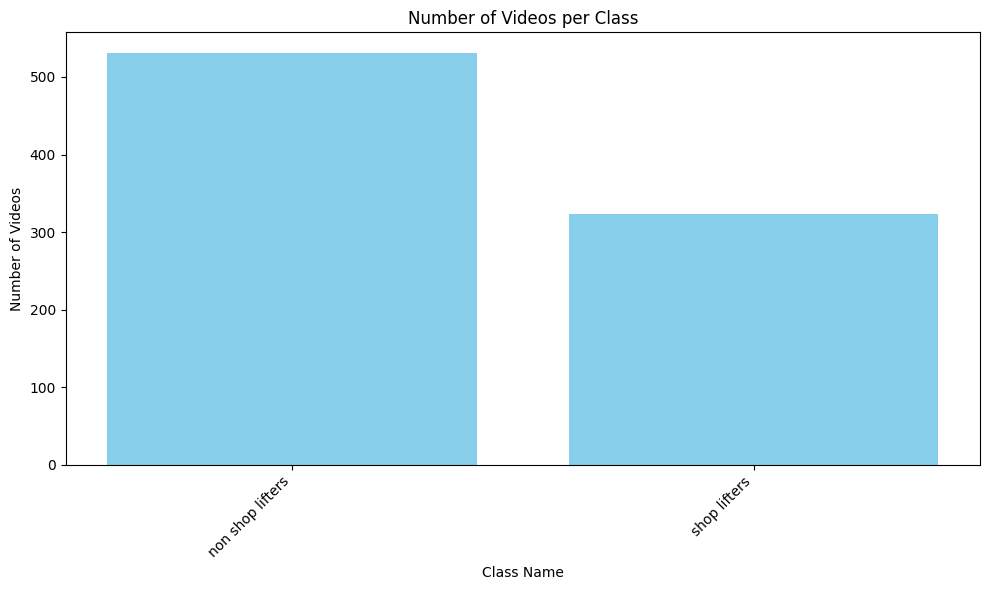

In [11]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(class_names, video_counts, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Videos')
plt.title('Number of Videos per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
video_counts

[531, 324]

## Video Augmentation

In [13]:
# # Define augmentation functions
# def random_flip(frames):
#     """Flip video frames horizontally with a 50% chance."""
#     if random.random() > 0.5:
#         return [cv2.flip(frame, 1) for frame in frames]
#     return frames

# def random_rotation(frames):
#     """Rotate frames by a random angle between -10 and 10 degrees."""
#     angle = random.uniform(-10, 10)
#     height, width = frames[0].shape[:2]
#     M = cv2.getRotationMatrix2D((width//2, height//2), angle, 1)
#     return [cv2.warpAffine(frame, M, (width, height)) for frame in frames]

# def random_crop(frames, crop_size):
#     """Randomly crop the video frames."""
#     height, width = frames[0].shape[:2]
#     crop_height, crop_width = crop_size
#     x = random.randint(0, width - crop_width)
#     y = random.randint(0, height - crop_height)
#     return [frame[y:y+crop_height, x:x+crop_width] for frame in frames]

# def frame_skip(frames, skip_step=2):
#     """Skip frames to reduce the frame rate."""
#     return frames[::skip_step]

# def adjust_brightness(frames, factor=1.5):
#     """Randomly adjust brightness by a factor between 0.5 and 1.5."""
#     factor = random.uniform(0.5, 1.5)
#     return [cv2.convertScaleAbs(frame, alpha=factor, beta=0) for frame in frames]



In [14]:
# # Example function to apply augmentations to a video
# def augment_video(frames):
#     """Apply a random combination of augmentations to video frames."""
#     frames = random_flip(frames)
#     frames = random_rotation(frames)
#     frames = random_crop(frames, crop_size=(100, 100))  # Change crop size as needed
#     frames = frame_skip(frames)
#     frames = adjust_brightness(frames)
#     return frames

In [15]:
# import time

# for video,label in gen:
#     # Perform data augmentation on the frames
#     augmented_frames = augment_video(video)

#     # Optionally, save the augmented video
#     out = cv2.VideoWriter(f'{time.now()}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (width, height))

#     for frame in augmented_frames:
#         out.write(frame)

#     out.release()




In [16]:
# augmented_video.shape

In [17]:
# plt.imshow(augmented_video[:,:,:,50])
# plt.axis('off')  # Hide axis
# plt.show()

In [19]:
import tensorflow as tf

# Build a larger 3D CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', input_shape=(num_frames, height, width, channels)),
    tf.keras.layers.MaxPooling3D((1, 2, 2)),  # Pooling down only on height and width
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu'),
    tf.keras.layers.MaxPooling3D((1, 2, 2)),  # Pooling down only on height and width
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv3D(256, (3, 3, 3), activation='relu'),
    tf.keras.layers.MaxPooling3D((1, 2, 2)),  # Pooling down only on height and width
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv3D(512, (3, 3, 3), activation='relu'),
    tf.keras.layers.MaxPooling3D((1, 2, 2)),  # Pooling down only on height and width
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv3D(512, (3, 3, 3), activation='relu'),
    tf.keras.layers.MaxPooling3D((1, 2, 2)),  # Pooling down only on height and width
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
    tf.keras.layers.Dense(2, activation='softmax')  
])



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 98, 98, 98, 64) │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 98, 49, 49, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 49, 49, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 96, 47, 47,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 96, 23, 23,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 23, 23,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 94, 21, 21,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 94, 10, 10,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 94, 10, 10,     │         1,024 │
│ (BatchNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 92, 8, 8, 512)  │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 92, 4, 4, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 92, 4, 4, 512)  │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 90, 2, 2, 512)  │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 90, 1, 1, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 90, 1, 1, 512)  │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46080)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    23,593,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 35,462,658 (135.28 MB)

 Trainable params: 35,458,690 (135.26 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [22]:
# Fit the model using the generators
steps_per_epoch = len(train_videos) // batch_size
validation_steps = len(test_videos) // batch_size

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('ShopLifter.keras',
    monitor='val_loss', 
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1)


callbacks = [early_stopping,lr_scheduler,checkpoint]

In [26]:
#  Train the model
hist = model.fit(gen,
                 steps_per_epoch=steps_per_epoch,
                 epochs=100,
                 validation_data=test_gen,
                 validation_steps=validation_steps,
                 batch_size=batch_size,
                callbacks = callbacks)

Epoch 1/100


I0000 00:00:1727205458.596912     126 service.cc:145] XLA service 0x7ac174018f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727205458.596991     126 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-09-24 19:17:51.287804: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,100,100,100]{4,3,2,1,0}, f32[4,64,98,98,98]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-24 19:17:51.470023: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.182373835s
Trying algorithm eng0{} for co

 84/171 ━━━━━━━━━━━━━━━━━━━━ 49s 564ms/step - accuracy: 0.5398 - loss: 1.0582


KeyboardInterrupt



In [ ]:


# Save the model
model.save('shop_lifter_model.h5')

